# PA005: High Value Customer Identification ( Insiders )

## 0.0. Planejamento da Solução ( IOT )

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização.
    
    
2. Conjunto de Dados
    - Vendas de um e-commerce online, durante o período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider 
                   1023| yes/1
                   

2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket Médio - Quanto o cliente gastou em média na empresa;
        - Alto LTV - Durante seu tempo na empresa, quanto você já gastou?;
        - Baixa Recência - Tempo entre as compras;
        - Alto Basket Size - Tamanho da cesta de compras;
        - Baixa probabilidade de Churn - Quando a pessoa parou de comprar de você;
        - Alta previsão de LTV;
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução;
        
    - Experiência de comora:
        - Média alta das avaliações


2. Quantos clientes farão parte do grupo?
    - Número total de clientes;
    - % do grupo Insiders.


3. Quais as principais características desses clientes?
    - Escrever características do cliente:
        - Idade;
        - Localização.
    
    - Escrever características do consumo
        - Atributos da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano;
    - Faturamento total do grupo.


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders;
    - Análise de Cohort - Análise onde eu marco uma pessoa no tempo.
    

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade (1 mes, 3 meses);
    - A pessoa precisa ser similar com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade (1 mes, 3 meses);
    - A pessoa precisa ser não similar com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B;
    - Teste A/B Bayesiano;
    - Teste de Hipóteses.


9. Quais ações o time de marketing pode realizar para aumentar o faturame1.
    - Desconto;
    - Preferência de compra;
    - Frete;
    - Visita a empresa.

# 0.0. Imports

In [282]:
import numpy as np
import pandas as pd
import seaborn as sns

import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [147]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [148]:
# read data
url='https://drive.google.com/file/d/1P2xz5nr3c8lPJ2esMb-N0uQs0TiTAeNW/view?usp=sharing'
url_='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_raw = pd.read_csv(url_, encoding='windows-1252')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [149]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [150]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Decrição dos Dados

In [151]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [152]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [153]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [154]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
132157,547656,22077,6 RIBBONS RUSTIC CHARM,2,22-Mar-17,1.65,13263.0,United Kingdom


## 1.2. Data Dimensions

In [155]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [156]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [157]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.4. Chek NA

In [158]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

### 1.5.1. df_missing

In [159]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [160]:
df_missing.shape

(135080, 8)

In [161]:
df_not_missing.shape

(406829, 8)

In [162]:
df_nm = df_not_missing.loc[:, ['invoice_no', 'customer_id']]
df_nm['customer_id'] = df_nm['customer_id'].astype(int)

In [163]:
df_merge = pd.merge(df_missing, df_nm, how='left', on='invoice_no')

In [164]:
df_merge.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom,NaN
1,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom,NaN
2,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom,NaN
3,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom,NaN
4,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom,NaN


In [165]:
# Não consigo fazer essa substitução

In [166]:
# fazendo o replace
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original data
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drio extra column 
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [167]:
# remova NA
df1 = df1.dropna(subset=['description'])
print('Removed Data: {:.2f}%'.format(100 * (1 - (df1.shape[0]/df_raw.shape[0]))))

Removed Data: 0.27%


In [168]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.6. Change Dtypes

In [169]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [170]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

In [171]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [172]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [173]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


#### 1.7.1.1. Numerical Attributes - Investigating

1. Quantity Negativa (Pode ser devolução)
2. Preço unitário igual a zero (pode ser promoção?)

### 1.7.2. Categorical Attributes

In [174]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [175]:
# Problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype(int)

# indentificacao:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


In [176]:
# Conferindo se todos os valores com letras são negativos
print('Total Number of invoices: {}'.format(len(df_letter_invoices)))
print('Total Number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))


# Assumption: Letras indicam retornos

Total Number of invoices: 9291
Total Number of negative quantity: 9288


#### Stock Code

In [177]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [178]:
# stock_code que são apenas letras
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# Acao:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [179]:
df1.head()

# Acao:
## 2. Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [180]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [181]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Name: country, dtype: float64

In [182]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Filtragem de Variáveis

In [183]:
df2 = df1.copy()

In [184]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Comunity', 'Unspecified'])]


df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [284]:
# Feature ideas:
## Moving Average - 7d - 15d - 30d
## Sazonalidade

In [285]:
df3 = df2.copy()

## 3.1. Feature Creation

In [286]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [287]:
# Gross Revenue - Faturamento - Quantity * Price
df2_purchases.loc[:, 'gross_revenue']  = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/home/tadeu/venvs/insiders_project/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [288]:
# Recency - Last Day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchases

In [289]:
 # Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity of product purchases

In [290]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5. Quantity of Products

In [291]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.6. Average Ticket Value

In [292]:
# Avg Ticket
avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [293]:
 # Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchase

In [294]:
df_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

In [295]:
df_aux = df2[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_=('invoice_date', 'max'),
                                                                                                         min_=('invoice_date', 'min'),
                                                                                                         days_=('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                                                         buy_=('invoice_no', 'count')).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id')

In [296]:
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

### 3.1.9. Number of Returns

In [297]:
 # Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
dtype: int64

### 3.1.10. Basket Size

In [298]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.11 Unique Basket Size

In [299]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0. EDA - Exploratory Data Analysis

In [300]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

In [313]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,0.486111,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.048780,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.045699,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.136364,22.0,26.666667,0.333333


In [301]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. Gross Revenue

In [302]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.206215,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.136111,952.0,1521.586957,2.695652
3339,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.014563,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.651475,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.076433,427.0,3868.650000,22.150000
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.178571,859.0,1052.454545,12.981818
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.120968,1535.0,2082.225806,14.612903
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,0.196429,8004.0,648.500000,0.693548
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,22.125000,0.084507,864.0,1794.821429,4.250000


In [304]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


In [308]:
np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])

278778.02

In [312]:
df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()

196556

## 4.2. Bivariate Analysis

# 5.0. Data Preparation

In [273]:
df5 = df4.copy()

In [274]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35 days 12:00:00,0.486111,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27 days 06:00:00,0.048780,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23 days 04:30:00,0.045699,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92 days 16:00:00,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8 days 14:24:00,0.136364,22.0,26.666667,0.333333


In [275]:
## Standard Scalaer
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['qtde_invoices'] = ss.fit_transform( df5[['qtde_invoices']] )
df5['qtde_items'] = ss.fit_transform( df5[['qtde_items']] )
df5['qtde_products'] = ss.fit_transform( df5[['qtde_products']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['avg_recency_days'] = ss.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = ss.fit_transform( df5[['frequency']] )
df5['qtde_returns'] = ss.fit_transform( df5[['qtde_returns']] )
df5['avg_basket_size'] = ss.fit_transform( df5[['avg_basket_size']] )
df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']] )

# 6.0. Feature Selection

In [276]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [277]:
X = df6.drop(columns = ['customer_id', 'avg_recency_days'])

In [278]:
clusters = [2, 3, 4, 5, 6, 7]

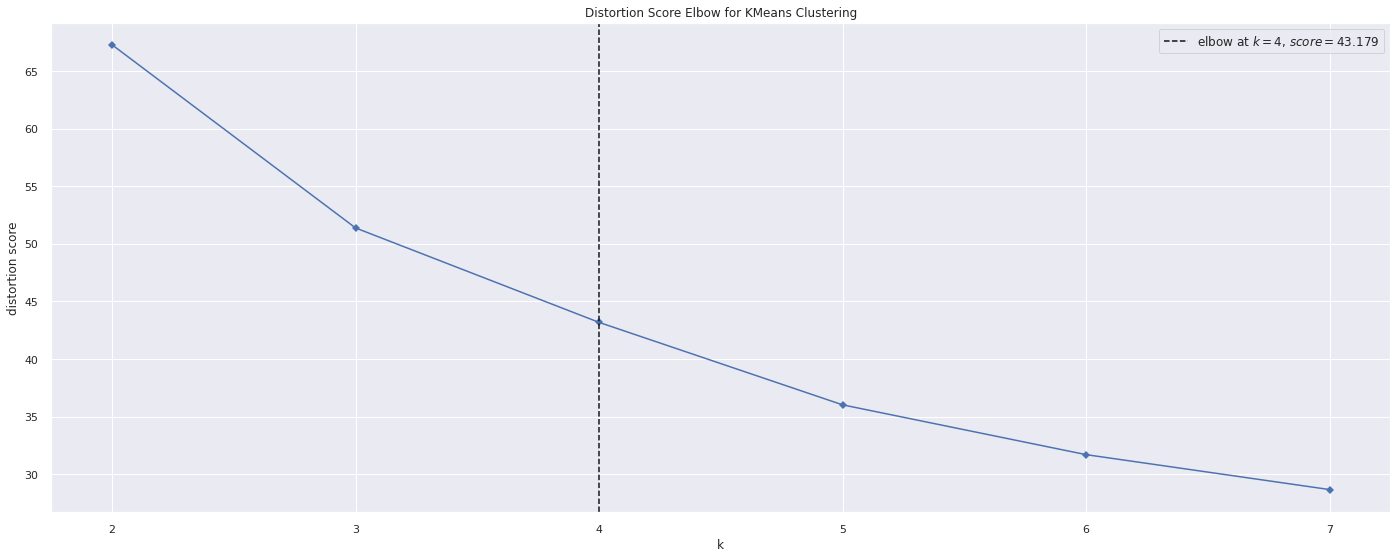

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [279]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False, metric = 'silhouette')
kmeans.fit(X)
kmeans.show()

## 7.1 Silhouette Analysis

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0. Model Training

## 8.1. K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.2. Cluster Validation

In [ ]:
from sklearn import metrics as m

In [ ]:
## WSS (Within-cluster sum of square)
print('WSS Value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

# 9.0. Cluster Analysis

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d plot

In [ ]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors = 90, random_state=42)
embedding = reducer.fit_transform(X)

In [ ]:
# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue = 'cluster',
                palette = sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data = df_viz)

## 9.4. Cluster Profile

In [ ]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

# 10.0. Deploy To Production